# **NL 조인**

- NL 조인 (Nested 조인) : 기본 조인이며 다중 for문처럼 조인하는 방식
- 수행 빈도가 많은 것은 인덱스를 타야 하므로 Inner 쪽(이중 for문으로 설명하자면 안쪽 for문을 의미) 테이블은 인덱스를 반드시 사용해야 한다.

 <br>
- NL 조인 실행 계획 : 아래는 NL 조인 실행 계획 예시이다. 사원이 Outer에 해당하고 고객이 Inner에 해당.


```sql
NESTED LOOPS
	TABLE ACCESS (BY INDEX ROWID) OF '사원' (TABLE)
		INDEX(RANGE SCAN) OF '사원_X1' (INDEX)
	TABLE ACCESS (BY INDEX ROWID) OF '고객' (TABLE)
		INDEX(RANGE SCAN) OF '고객_X1' (INDEX)​
 ```

<br>

- 힌트를 사용한 NL 조인 방법

```sql
-- ordered : FROM절에 기술한 순서대로 조인
-- use_nl(c) : NL 방식으로 조인하라는 의미
SELECT /*+ ordered use_nl(c) */
	*
FROM 사원 e, 고객 c
WHERE ...

-- leading : 조인 순서 정하기
-- use_hash : 해시 조인을 사용하라는 의미로 뒤에서 설명한다.
SELECT /*+ leading(C, A, D, B) use_nl(A) use_nl(D) use_hash(B) */
	*
FROM A, B, C, D
WHERE ...

-- 순서를 기술하지 않았다면, 옵티마이저가 알아서 순서를 정하여 NL 조인한다.
SELECT /*+ use_nl(A, B, C, D) */
	*
FROM A, B, C, D
WHERE ...
```

<br>

- NL 조인 특징
  - NL 조인은 인덱스를 거의 사용하기 때문에 랜덤 액세스 위주의 조인 방식이다. 당연하게도 대량 데이터를 조인하게 되면 비효율이 발생.
  - 다중 for문처럼 NL 조인은 한 레코드씩 순차적으로 진행한다. 따라서 부분 범위 처리(3.2장에서 설명)를 하게 되면 Fetch Size만큼 읽어 들이면 바로 멈추기 때문에 성능이 좋다.
  - 다른 조인보다 인덱스 구성 전략이 특히 중요하다.


- NL 조인 튜닝
  - 일반적인 인덱스 튜닝 방식대로 각각의 쿼리들을 최대한 튜닝.
  - 조건절에 해당하는 Outer 로우 수가 많고 조인에 성공한 Inner 로우 수가 적다면, 조인 순서를 바꿔보는 것도 좋다.
  - 만약 위처럼 하여도 불가능할 경우, 뒤에서 설명할 소트 머지 조인 또는 해시 조인을 사용해본다.


- NL 조인 확장 메커니즘 : 오라클이 NL 조인 성능을 높이기 위해 개선한 알고리즘 방식들
  - NL 조인 기본 실행계획

```sql
NESTED LOOPS
	TABLE ACCESS (BY INDEX ROWID) OF '사원' (TABLE)
		INDEX(RANGE SCAN) OF '사원_X1' (INDEX)
	TABLE ACCESS (BY INDEX ROWID) OF '고객' (TABLE)
		INDEX(RANGE SCAN) OF '고객_X1' (INDEX)​
 ```

  - 테이블 Prefetch : 디스크 I/O가 필요해지면 곧 읽게 될 블록까지 미리 읽어서 버퍼 캐시에 적재하는 기능이다. 아래는 Inner 쪽 테이블인 고객의 대한 디스크 I/O 과정에 테이블 PreFecth 기능이 작동된 실행계획이다.

```sql
TABLE ACCESS BY INDEX ROWID OF 고객
	NESTED LOOPS
		TABLE ACCESS BY INDEX ROWID OF 사원
			INDEX RANGE SCAN OF 사원_X1
		INDEX RANGE SCAN OF 고객_X1​
```

  - 배치 I/O : 디스크 I/O을 미뤘다가 일정량 쌓이면 한꺼번에 처리하는 기능이다. 아래는 Inner 쪽 테이블인 고객의 대한 디스크 I/O 과정에 배치 I/O 기능이 작동된 실행계획이다.

```sql
NESTED LOOPS
	NESTED LOOPS
		TABLE ACCESS BY INDEX ROWID OF 사원
			INDEX RANGE SCAN OF 사원_X1
		INDEX RANGE SCAN OF 고객_X1
	TABLE ACCESS BY INDEX ROWID OF 고객​
```

- NL 조인 자가 진단 : 쿼리와 인덱스가 아래와 같을 때, 인덱스를 튜닝해야 한다. 정답은 책에 기술되어있지 않음

```sql
-- 인덱스 PRA_HST_STC_N1 : SALE_ORG_ID + STRD_GRP_ID + STRD_ID + STC_DT
select *
	FROM PRA_HST_STC a, ODM_TRMS b
WHERE
	a.SALE_ORG_ID = :sale_org_id
	AND a.STRD_GR_ID = b.STRD_GRP_ID
	AND a.STRD_ID = b.STRD_ID
	AND b.TRMS_DT = :trms_dt
ORDER BY a.STC_DT desc​
```

  - 추측 1. Outer는 PRA_HST_STC 테이블이고, Inner는 ODM_TRMS.
  - 추측 2. 따라서 조건절 중, 'AND a.STRD_GR_ID = b.STRD_GRP_ID AND a.STRD_ID = b.STRD_ID'은 INNER 쪽을 찾을 때 사용하는 조건절.
  - 추측 3. 따라서 인덱스 컬럼 중 두 번째(STRD_GRP_ID)와 세 번째 (STRD_ID)는 인덱스에 의미가 없다.
  - 추측 4. STC_DT는 ORDER BY를 위해 필요하므로 사용하는 것이 좋다.
  - 즉, SALE_ORG_ID + STC_DT 만 존재하면 될 것으로 판단.


# **소트 머지 조인**

- 조인 컬럼에 인덱스가 없을 때, 또는 대량 데이터 조인이어서 인덱스가 효과적이지 않을 때, NL조인 대신 소트 머지 조인이나 해시 조인을 사용.
- 소트 머지 조인은 PGA 공간을 사용하는데 SGA와 비교해서 설명하면 아래와 같다.


- SGA(System Global Area) :  1.2장에서 설명했던 것처럼 캐싱된 데이터를 저장하는 메모리
  - 여러 프로세스가 공유하여 사용.
  - 단 공유를 하지만, 동시에 사용은 할 수 없으므로 락이 필요하므로 Latch라는 방식으로 락을 사용.
- PGA(Process Global Area) :  각각의 오라클 서버 프로세스가 가지고 있는 메모리
  - 프로세스에 종속적인 고유 데이터를 저장.
  - 프로세스끼리 공유하지 않아 Lock도 필요 없고 속도가 빠르다.
  - 단, 메모리 공간이 작아 데이터를 모두 저장할 수 없을 때는 Temp 테이블스페이스를 사용.


- 소트 머지 조인(Sort Merge Join) : 각각의 쿼리(Outer와 Inner)를 소트 후에 머지하여 NL 조인을 하는 방식.
  - 소트 단계에서 얻은 데이터를 PGA에 저장한 후 NL 조인하기 때문에 대량 데이터를 스캔할 때 빠르다.
  - 과정
    - 소트 단계 : 양쪽 집합을 조인 컬럼 기준으로 정렬하여 PGA에 저장한다.
    - 머지 단계 : 정렬한 양쪽 집합을 NL 조인
    
```sql
-- 소트 단계 예시
-- use_merge : 소트 머지 조인을 사용하라는 의미이다.
-- 조인 컬럼은 사원 테이블은 '사원번호', 고객 테이블은 '관리자사원번호'이다.
SELECT /* ordered use_merge(c) */
	...
FROM 사원 e, 고객 c
WHERE c.관리자사원번호 = e.사원번호
AND e.입사일자 >= '19960101'
AND e.부서코드 >= 'Z123'
AND c.최종주문금액 >= 20000

-- 양쪽 집합을 조인 컬럼 기준으로 정렬하면 다음과 같다.

-- 사원 데이터를 조인컬럼인 사원번호 기준으로 정렬
SELECT
	...
FROM 사원
WHERE 입사일자 >= '19960101'
AND 부서코드 >= 'Z123'
ORDER BY 사원번호


-- 고객 데이터를 조인컬럼인 관리자사원번호 기준으로 정렬
SELECT
	...
FROM 고객
WHERE 최종주문금액 >= 20000
ORDER BY 관리자사원번호
```


- 소트 머지 조인 장점
  - Inner를 스캔할 때 데이터가 정렬되어 있기 때문에 조인에 실패하는 레코드를 만나는 순간 멈출 수 있다. 즉 Inner를 Full Scan 하지 않아 빠르다.

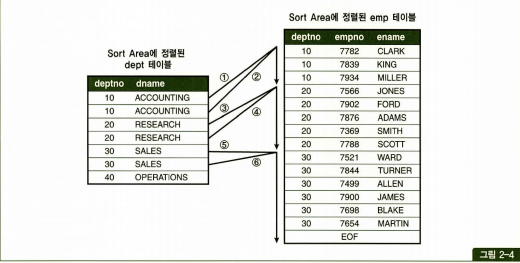

  - NL 조인은 인덱스를 이용하여 SGA를 사용하지만 소트 머지 조인은 PGA을 사용하여 Latch 획득 과정이 없어 빠르다.
  - 소트 머지 조인은 소트 하는 과정에서 조인을 위한 인덱스를 실시간으로 만들어내는 과정이라고 생각하면 쉽다. 따라서 조인 컬럼에 대한 인덱스가 각각의 테이블에 없어도 빠르다.


- 소트 머지 조인 주용도
조인 조건식이 등치(=) 조건이 아닌 대량 데이터 조인
조인 조건식이 아예 없는 조인 (Cross Join, 카테시안 곱)


소트 머지 조인 실행 계획은 아래와 같다.


```sql
-- 소트 후, 위쪽 테이블 기준으로 아래쪽 테이블을 머지 조인
-- 소트할 때 인덱스를 사용해서 인덱스로 표현된 것 뿐이지, 인덱스 없이 스캔했다면 TABLE FULL SCAN으로 나올 수 도 있음
MERGE JOIN
	SORT (JOIN)
		TABLE ACCESS (BY INDEX ROWID) OF '사원' TABLE
			INDEX (RAGNE SCAN) OF '사원_X1' (INDEX)
	SORT (JOIN)
		TABLE ACCESS (BY INDEX ROWID) OF '고객' TABLE
			INDEX (RAGNE SCAN) OF '고객_X1' (INDEX)​
```

# **해시 조인**

- 소트 머지 조인은 양쪽 테이블을 정렬하는 부담이 있지만 해시 조인은 그런 부담이 없어 더 좋으며 해시 조인도 PGA를 사용.


- 해시 조인(Hash Join) : 조인 컬럼을 Key로 하는 해시 맵을 만들어 NL 조인을 하는 방식이다.

  - Build 단계 : 작은 쪽 테이블(Build Input)을 기준으로 조인 컬럼을 Key로 하여 해시 맵을 생성 한다. 단, 아래는 ordered를 명시하였으므로 먼저 읽은 사원 테이블 기준으로 해시 맵을 생성.

```sql
-- use_hash : 해시 조인을 사용하라는 의미이다.
-- ordered를 명시하였으므로 먼저 읽은 사원 테이블을 기준으로 해시 맵을 생성
-- swap_join_inputs(e) 힌트를 사용하면 명시한 테이블 기준으로 해시 맵을 생성
SELECT /* ordered use_hash(c) */
	...
FROM 사원 e, 고객 c
WHERE c.관리자사원번호 = e.사원번호
AND e.입사일자 >= '19960101'
AND e.부서코드 >= 'Z123'
AND c.최종주문금액 >= 20000

-- 사원 테이블을 읽어 해시 맵을 생성
-- 조인 컬럼인 사원번호를 해시 맵의 키 값으로 사용
SELECT
	...
FROM 사원
WHERE 입사일자 >= '19960101'
AND 부서코드 >= 'Z123'
```

  - Probe 단계 : 큰 쪽 테이블(Probe Input)을 읽어 조인 컬럼을 가지고 해시 맵을 탐색 하면서 조인

```sql
-- 고객 테이블을 하나씩 읽어 앞서 생성한 해시 맵을 탐색
-- 관리자사원번호를 해시 함수에 입력
SELECT
	...
FROM 고객
WHERE 최종주문금액 >= 20000
```

- 해시 조인의 PL/SQL 코드로 표현하면 다음과 같다. 큰 쪽 테이블을 outer로 두고 생성한 해시 맵에서 Outer의 조인컬럼 기준으로 해시 맵을 탐색 한다.

```sql
begin
	for outer in (SELECT ... FROM 고객 WHERE 최종주문금액 >= 20000) -- Probe 쿼리
	loop -- outer 루프
		for inner in (SELECT ... FROM 해시맵 WHERE 사원번호 = outer.관리자사원번호)
		loop -- inner 루프
        	dbms_output.put_line(..);
		end loop;
	end loop;
end
```

- 대용량 Build Input 처리 : 해시 조인을 하려고 작은 테이블을 찾으려고 하였지만, 테이블 둘 다 대용량일 경우에는 DBMS는 Divide & Conquer 방식으로 해시를 만든다.
  - 파티션 단계 : 두 테이블을 쪼개서 각각 여러 개의 해시 맵을 만든다. 기존 해시 조인과 다르게 양쪽 테이블 모두 해시 맵을 만든다. 그러고 나서 서로 짝을 맺어준다.
  - 조인 단계 : 짝이 맺어진 서로의 맵끼리 해시 조인(Build단계, Prove단계)을 수행한다.


- 해시 조인 장점
  - 해시 맵은 PGA 영역에 할당된 Hash Area에 저장한다. 소트 머지 조인과 마찬가지로 PGA를 사용하므로 대량 데이터를 스캔할 때 NL조인 보다 빠르다.
  - 소트 머지 조인은 두 테이블을 정렬한 상태로 만든 데이터를 PGA에 저장해야 하지만(또 크기가 크면 Temp 테이블 스페이스를 사용) , 해시 맵은 하나의 테이블만 PGA(똑같이 Temp 테이블 스페이스를 사용하긴 함)를 사용하므로 더 빠르다.


- 해시 조인 실행 계획은 아래와 같다.

```sql
-- 위쪽 테이블 기준으로 해시 맵을 생성한 후, 아래쪽 테이블에서 읽은 조인 키값으로 해시 맵 탐색
-- 소트할 때 인덱스를 사용해서 인덱스로 표현된 것 뿐이지, 인덱스 없이 스캔했다면 TABLE FULL SCAN으로 나올 수 도 있음
HASH JOIN
  	TABLE ACCESS (BY INDEX ROWID) OF '사원' TABLE
  		INDEX (RAGNE SCAN) OF '사원_X1' (INDEX)
  	TABLE ACCESS (BY INDEX ROWID) OF '고객' TABLE
  		INDEX (RAGNE SCAN) OF '고객_X1' (INDEX)​
```



- 조인 메서드 선택 기준
  - 일반적인 경우
    - 소량 데이터 조인할 때 → NL 조인
    - 대량 데이터 조인할 때 → 해시 조인
    - 조건식이 등치가 아닐 경우 → 소트 머지 조인
  - 빈도수가 높은 쿼리에 경우
    - NL 조인과 해시 조인 성능이 같으면, NL 조인
    - 해시 조인이 약간 더 빨라도 NL 조인
    - NL 조인보다 해시 조인이 매우 빠른 경우, 해시 조인
  - 이유는 해시 조인에 의해 생성된 해시 맵은 단 하나의 쿼리를 위해서만 사용하는 데이터이다. 따라서 같은 쿼리를 100개 프로세스가 동시에 수행하면, 100개 해시 맵이 생성된다.
  - 해시 조인은 아래와 같은 경우에만 사용하자
    - 수행 빈도가 낮고
    - 쿼리 수행 시간이 오래 걸리는
    - 대량 데이터를 조인할 때


# **서브 쿼리 조인**

- 서브 쿼리 : SQL문 안에 괄호로 묶은 별도의 쿼리 블록
  - 인라인 뷰 : FROM 절에 사용한 서브 쿼리
  - 중첩된 : WHERE 절에 사용한 서브 쿼리
  - 스칼라 서브 쿼리 : 한 레코드당 정확히 하나의 값을 반환하는 서브 쿼리


- 쿼리 변환 : 옵티마이저가 SQL을 분석해 더 나은 성능을 위해 의미가 같은 SQL 문장으로 쿼리를 변환하는 작업
- 단일 쿼리를 옵티마이저가 쿼리 변환을 하여 더 나은 성능을 보여줄 수 있다.
- 일반적으로 서브 쿼리가 포함된 쿼리는 옵티마이저는 각각의 쿼리를 나눠서 쿼리 변환을 하여 각각에 대해 더 나은 성능을 내도록 한다.
  - 더 나은 성능을 위해 각각의 쿼리를 변환하였어도 전체 쿼리에 대해서 최적화가 되었다고 할 수 없다.
  - 나무가 아닌 숲 전체를 바라보는 관점에서 쿼리를 이해하려면 먼저 서브 쿼리를 풀어내야만 한다.


- 아래는 중첩된 서브 쿼리를 잘 사용하는 방법에 대해 설명.


- 필터 오퍼레이션 : 서브 쿼리를 필터 방식으로 처리하는 방법

```sql
-- no_unnest : 서브쿼리를 쿼리 하나로 판단하여 최적하지 말고 그대로 수행하라는 의미의 힌트. 중첩 해제를 하지 마라.
SELECT
	...
FROM 고객 c
WHERE c.가입일시 >= '19960101'
AND EXISTS (
	SELECT /*+ no_unnest */
    	'x'
	FROM 거래
	WHERE 고객번호 = c.고객번호
	AND 거래일시 >= '20210621'  
)
```

  - 필터 방식이란 마치 NL 조인처럼 동작하도록 하는 방식.
  - 즉, 두 개의 쿼리를 각각 최적화하지 않고, NL 조인처럼 하나의 쿼리로 판단하여 최적화
  - 실행계획은 아래와 같다.

```sql
-- 'FILTER'를 'NESTED LOOP'라고 생각하면 된다.
FILTER
  	TABLE ACCESS (BY INDEX ROWID) OF '고객' TABLE
  		INDEX (RAGNE SCAN) OF '고객_X1' (INDEX)
	INDEX (RAGNE SCAN) OF '거래_X1' (INDEX)
```  

  - NL 조인과 차이점
    - 서브 쿼리 조건절에 해당하는 값이 존재하면 조건절이 참이 true가 되었으므로 바로 break
    - 서브 쿼리 조건절에 따른 결과를 캐싱한다. 동일한 조건의 결과가 올 경우 바로 캐시에서 찾을 수 있으므로 빠름.
    - 항상 메인 쿼리가 Outer, 서브 쿼리가 Inner



- Unnesting 방식 : 메인과 서브 쿼리 간의 계층구조를 없애고, 서로 같은 레벨로 쿼리를 처리하는 방식이다. 위에서 설명한 필터 방식과 비교해서 이해하면 쉽다.

| |Filter 방식|Unnesting 방식|
|--|--|--|
|힌트|no_unnest|unnest|
|Outer와 Inner쿼리|항상 서브쿼리가 Inner|힌트를 이용해서 선택 가능|
|조인방식|NL 조인방식|NL조인, 해시조인등 다양하게 가능|

  - unnest 힌트로 유도 가능
  - 서브 쿼리가 메인 쿼리 보다 먼저 처리될 수 도 있다.
  - 다양한 최적화 기법을 줄 수 있어 필터 방식보다 더 좋은 실행 경로를 찾을 수 있다.
  - 서브 쿼리에 ROWNUM을 사용하면 unnest 힌트를 사용한다고 하여도 서브 쿼리를 최적화하지 않으니 ROWNUM을 서브 쿼리에 쓸 때 조심.


- 서브 쿼리 Pushing : 서브쿼리 필터링을 가능한 한 앞 단계에서 처리하도록 강제하는 기능
  - 조건절에 존재하는 서브 쿼리에 해당하는 데이터가 적다면 서브 쿼리가 먼저 수행되는 것이 좋다. 하지만 필터 방식의 서브 쿼리는 대게 맨 마지막에 처리되므로, 이를 가장 먼저 처리되도록 강제하는 기능.  
  - push_subq 힌트로 유도
  - 필터 방식에서만 사용 가능하기 때문에 no_unnest 힌트와 같이 힌트를 사용.
  - 반대로, 가장 나중에 처리하게 하려면 no_push_subq를 사용하면 된다.

- 인라인 뷰 서브 쿼리와 조인
  - 일반적으로 서브 쿼리가 포함된 쿼리는 옵티마이저는 각각의 쿼리를 나눠서 쿼리 변환을 하여 각각에 대해 더 나은 성능을 내도록 한다.
  - 인라인 뷰도 옵티마이저가 독립적으로 최적화하기 때문에 merge 힌트를 사용하여 다르게 처리할 수 있다.

```sql
-- T에 대한 인라인 뷰 안에서는 조건에 해당하는 모든 데이터를 읽어야 한다.
-- 모든 데이터를 읽고 결국엔 고객 테이블의 고객번호와 조인되는 값만 출력한다.
-- 따라서 불필요한 데이터를 조회해서 비효율적이다.
SELECT
	...
FROM 고객 C
	,(SELECT ... FROM 거래 WHERE 거래일시 >= trunc(sysdate, 'mm') GROUP BY 고객번호) T
WHERE C.가입일시 >= trunc(add_months(sysdate, -1), 'mm')
	AND T.고객번호 = C.고객번호
    
    
-- merge : 뷰를 메인 쿼리와 머지하라는 힌트이다.
-- 머지를 하게되면 고객 테이블을 먼저 읽고 조인할 때는 해당 고객들에 대한 데이터만 읽는다.
SELECT
	...
FROM 고객 C
	,(SELECT /*+ merge */ ... FROM 거래 WHERE 거래일시 >= trunc(sysdate, 'mm') GROUP BY 고객번호) T
WHERE C.가입일시 >= trunc(add_months(sysdate, -1), 'mm')
	AND T.고객번호 = C.고객번호
```

- 스칼라 서브 쿼리와 조인
  - 스칼라 서브 쿼리는 NL 조인 방식으로 실행.
  - 필터 서브 쿼리처럼 스칼라 서브 쿼리도 캐싱 기능을 사용하여 동일한 입력값에 대해서 캐싱해놓는다.
  - 스칼라 서브 쿼리는 2개 이상의 항목을 조회할 수 없으므로 그럴 경우에는, 해당 쿼리를 인라인 뷰로 사용하는 편이 낫다.
  - 스칼라 서브 쿼리도 unnest 사용이 가능.